In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 14:52:43 2020
@author: nooryoussef

Ploting a single step change in propoensity and the proportion of sites 
"""
import numpy as np
import pandas as pd
import misc_functions as mf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def sim_sequences(main_rst, protein, trial):
    '''
        creates an array of the amino acid index sequences realized during simulation
    '''
    with open("../data/eq_seqs/" + protein + "/" + protein + "_equilibrium_cdn_seq_t" + trial + ".txt") as file:
        start_seq = file.readline().strip()
    
    # translate codon sequence to amino acid idx sequence
    seq = mf.Codon_to_AA(mf.Codon_to_Cindex(start_seq))  
    
    num_subs = main_rst["num_sub"].max() +1 
    num_sites = len(seq)
    sequences = np.zeros((num_subs, num_sites))
    
    sequences[0] = seq
    for sub in range(1, num_subs):
        site =  int(main_rst['site'][sub])
        aa  = int(mf.AminoAcid[main_rst['new_aa'][sub]])
        
        seq[site] = aa
        sequences[sub] = seq
        
    return sequences

def prop_res_aa(ss_freq, aa_sequences):
    '''
        returns an array of the propensities of the resident amino acids at all sites throughout the simulations 
        
        ss_freq [num_subs, num_sites, 20]: the site-specific propensity at all sites throughtout the simulation
        aa_sequences: an array of the sequences throughout the simulations
        
    '''
    num_subs, num_sites = aa_sequences.shape
    
    propensity_res_aa = np.zeros((num_subs, num_sites))
    for sub in range(num_subs):
        res_aas = aa_sequences[sub]
        propensity_res_aa[sub] = [ss_freq[sub, site, int(res_aas[site])] for site in range(num_sites)]
    return(propensity_res_aa)

In [3]:
protein = "1pek"
trial = str(25)

main_rst  = pd.read_csv("../output/" + protein + '_Ne2_t' + trial + '_nsubs_5e2_main_rst_diff_eq_seq.txt', delimiter = " ")

# change in propensity of resident amino acids 
ss_freq                 = np.load("../output/" + protein + '_Ne2_t' + trial + '_nsubs_5e2_ssfreq.npy')  #(sub, site, aa)
aa_sequences            = sim_sequences(main_rst, protein, trial)
res_aa_propensity_array = prop_res_aa(ss_freq, aa_sequences)
delta_res_prop          = np.diff(res_aa_propensity_array, axis = 0)

num_subs, num_sites = aa_sequences.shape

# change in stability 
ddG = [main_rst["dG"][x+1] - main_rst["dG"][x] for x in range(num_subs-1)]

# proportion of sites for which pi_a^h < 0
P_neg = [np.sum(delta_res_prop[sub] < 0) / num_sites for sub in range(num_subs-1)]


In [4]:
## Remove synonymous substitutions # 
start = 200
stop = 300 

x = [i for i in range(start,stop)]
y = P_neg[start:stop]
z = ddG[start:stop]
w = delta_res_prop[start:stop]
v = list(main_rst[(main_rst["num_sub"] > start) & (main_rst["num_sub"] < stop)]["site"])
v = [int(s) for s in v]

x_ns = []; Pneg_ns = []; ddG_ns = []; delta_res_prop_ns = np.zeros((stop-start, 279)); sub_site_ns = []
a = 0
for i,j,k,l,m in zip(x, y, z, w, v):
    if j!= 0 and k!= 0: 
        x_ns.append(i)
        Pneg_ns.append(j*100)
        ddG_ns.append(k)
        delta_res_prop_ns[a] = l
        a +=1
        sub_site_ns.append(m)
delta_res_prop_ns = delta_res_prop_ns[:len(sub_site_ns)]

Text(-0.15, 1.1, 'B')

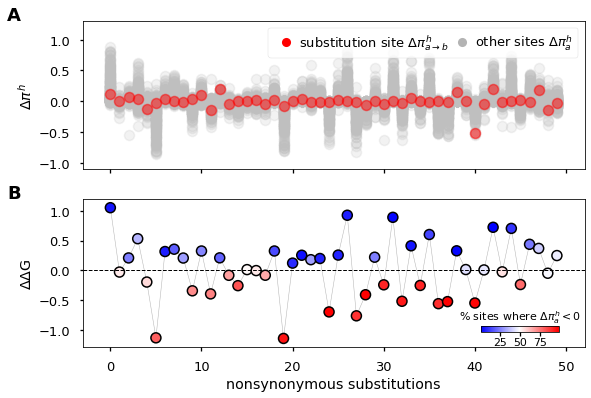

In [5]:
plt.style.use('seaborn-talk')

f, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = 'row', figsize = (9,6))

### subplot A ###
for x in range(50):
    ax1.scatter([x]*num_sites, delta_res_prop_ns[x], marker="o", facecolors='0.75',s = 100,
                edgecolors="0.75", linewidth= 1.5, alpha=0.2)

for x in range(50):
    sub_site = sub_site_ns[x]
    ax1.scatter(x, delta_res_prop_ns[x, sub_site], marker="o", facecolors='r', s = 100,
                edgecolors="r", linewidth= 1.5,  alpha=0.5 )

# legend 
custom_lines = [Line2D([0], [0], color='r', marker='o', markeredgecolor= "r",  
                linestyle='None', label = r"substitution site $\Delta \pi^h_{a \rightarrow b}$ "),
                Line2D([0], [0], color='0.7', marker='o', markeredgecolor= "0.8",
                linestyle='None', label = r"other sites $\Delta \pi^h_a$")]
ax1.legend(handles= custom_lines, loc='upper right',title="", ncol=4, columnspacing= 0.001, labelspacing = 0.1, handletextpad=0 , frameon = True, fancybox = True)
ax1.set_ylim(-1.1, 1.3)
    
### subplot B ###
sc = ax2.scatter([x for x in range(50)], ddG_ns[:50], c =  Pneg_ns[:50], s = 100, cmap = 'bwr', 
                 marker="o", edgecolor= 'k', linewidth= 1.5, label = r"$P_{anti-stokes}$", zorder=2)

ax2.plot([x for x in range(50)], ddG_ns[:50], color = '0.7', linewidth = 0.5, zorder=1)
ax2.axhline(0, ls = '--', color = 'k', lw = 1)


# color bar 
cbaxes = f.add_axes([0.74, 0.16, 0.12, 0.015]) 
cbar= plt.colorbar(sc, orientation = "horizontal", cax = cbaxes)
cbar.ax.set_title('% sites where $\Delta \pi_a^h <0$', fontsize = 11)
cbar.ax.xaxis.set_tick_params(pad=1.5)
cbar.ax.tick_params(labelsize=11)



# labels 
ax1.set_ylabel(r'$\Delta \pi^h$')
ax2.set_ylabel('$\Delta \Delta$G')
ax2.set_xlabel('nonsynonymous substitutions')


ax1.text(-0.15, 1.1, "A", transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top')
ax2.text(-0.15, 1.1, "B", transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top')

#plt.savefig('../figures/Figure4new.png', dpi = 450)